#Разведочный анализ данных
#Импортируем библиотеки

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,)
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
%matplotlib inline 

Data extraction - загружаем датасет

In [2]:
X_full = pd.read_csv('/Users/levashev/Desktop/METABRIC_RNA_Mutation.csv', low_memory=False)

Трансформируем датасет с целью упрощения работы с ним. Отсеиваем генетические признаки и оставляем клинические

In [3]:
clinical_df = X_full.iloc[:, :31]

Так как данные являются цензурированными с правой стороны, 
то мы будем работать с инструментами, позволяющими строить модели, учитывающие цензурирование.
Для описательных целей построим кривые Каплана-Мейера. А для анализа влияния аттрибутов/фич - 
модель пропорциональных рисков (Регрессия Кокса).
Вне зависимости от выбранной библиотеки (lifelines или scikit-survival) очевидно, что в датасете Каггла неверно
расставлены значения: 0 - умер, 1 - живой. Тогда как в действительности должно быть иначе: 1 - есть событие, т.е.смерть в данном случае, 0 - события нет (причем это и есть цензурирование).
Данные с сайта проекта подтверждают наше предположение.
https://www.cbioportal.org/study/summary?id=brca_metabric 
Итак, меняем 0 и 1 местами для целевой переменной overall_survival

In [4]:
clinical_df_inverted = clinical_df.copy()
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])
print(clinical_df_inverted.head(5))

   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
0                 claudin-low     1.0       

In [5]:
KM_df = clinical_df_inverted.copy()

Для работы с y и scikitsurv кодируем фичу как булеву

In [6]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

Учитывая большое количество фич, удалим неинформативные - patient_id, cohort, cancer_type (1903 это один тип), oncotree_code (он дублирует фичу cancer_type_detailed). Наверное, правильным будет удалить death_from_cancer как очевидно самую информативную для выбранных переменных, но вернемся к этому позже.

In [7]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code'], axis=1, inplace=True)

In [8]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [9]:
y = KM_df.copy()
y.columns

Index(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
       'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype',
       'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

В целевой переменной - overall_survival и overall_survival_months

In [10]:
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'], axis=1, inplace=True)

In [11]:
y_rear = y[['overall_survival', 'overall_survival_months']]
print(y_rear)

      overall_survival  overall_survival_months
0                False               140.500000
1                False                84.633333
2                 True               163.700000
3                False               164.933333
4                 True                41.366667
...                ...                      ...
1899             False               196.866667
1900              True                44.733333
1901              True               175.966667
1902              True                86.233333
1903              True               201.900000

[1904 rows x 2 columns]


In [12]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()
print(new_y)

[[False 140.5]
 [False 84.63333333]
 [True 163.7]
 ...
 [True 175.9666667]
 [True 86.23333333]
 [True 201.9]]


In [13]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [14]:
X_train, X_test, struct_y_train, struct_y_test = train_test_split(X, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [15]:
num_columns = [cname for cname in X_train.columns if 
                X[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [16]:
cat_columns = [cname for cname in X_train.columns if
                    X[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


In [17]:
my_columns = cat_columns + num_columns

In [18]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

In [19]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [21]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(X_train)
X_pandas

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
996,-0.861298,-0.509626,-0.634485,0.786442,-0.242274,-0.407161,0.000759,-1.208478,-1.039190,0.409777,...,1.0,2.0,0.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0
31,-1.084161,-0.509626,-0.634485,0.786442,-0.480943,-0.645299,-0.835530,0.827487,0.493162,0.409777,...,1.0,2.0,0.0,1.0,1.0,9.0,1.0,1.0,1.0,2.0
796,-0.516945,-0.509626,0.912139,-1.271550,-0.480943,0.069116,0.035898,0.827487,0.237770,0.409777,...,1.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
457,-0.174140,-0.509626,-0.634485,0.786442,-0.480943,-0.169022,-0.719574,0.827487,4.707131,0.409777,...,1.0,2.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,2.0
1146,-2.179126,1.962223,0.912139,0.786442,3.576434,0.069116,1.775240,0.827487,-0.400710,0.409777,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.188785,-0.509626,0.912139,0.786442,-0.003604,-0.645299,0.896784,0.827487,-0.400710,0.409777,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
1216,0.506828,-0.509626,-0.634485,-1.271550,-0.480943,-0.645299,-0.868911,-1.208478,-0.719950,-1.171197,...,1.0,2.0,0.0,4.0,0.0,2.0,1.0,0.0,1.0,2.0
1653,1.583996,-0.509626,0.912139,-1.271550,-0.480943,1.974223,0.044682,-1.208478,0.557010,0.409777,...,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0
559,0.013900,-0.509626,-0.634485,-1.271550,-0.480943,-0.407161,-0.872425,0.827487,-0.847646,-1.171197,...,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0


Построим кривую КМ

Text(0.5, 0, 'time')

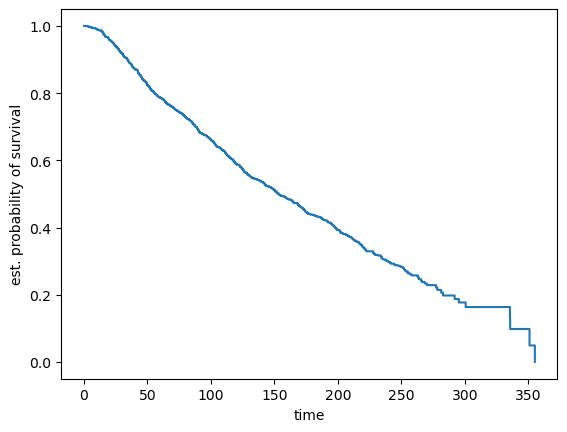

In [22]:
time, survival_prob = kaplan_meier_estimator(struct_y_train["overall_survival"], struct_y_train["overall_survival_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival")
plt.xlabel("time")

In [23]:
X_pandas["cat__integrative_cluster"].value_counts()

9.0     222
3.0     219
4.0     208
1.0     168
6.0     153
8.0     150
10.0    115
0.0     102
7.0      68
2.0      62
5.0      56
Name: cat__integrative_cluster, dtype: int64

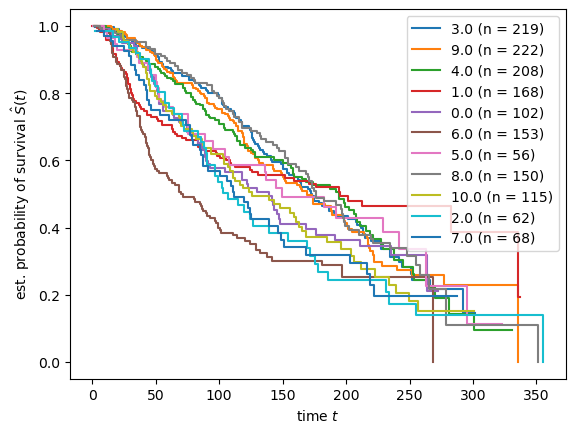

In [24]:
for value in X_pandas["cat__integrative_cluster"].unique():
    mask = X_pandas["cat__integrative_cluster"] == value
    time_grade, survival_prob_grade = kaplan_meier_estimator(struct_y_train["overall_survival"][mask],
                                                           struct_y_train["overall_survival_months"][mask])
    plt.step(time_grade, survival_prob_grade, where="post",
             label="%s (n = %d)" % (value, mask.sum()))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Можно проводить подгрупповой анализ и сравнивать различия при помощи лог-ранкового теста, но
для того, чтобы учесть сразу все признаки, нам нужна модель пропорциональных рисков.

In [25]:
X_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 996 to 684
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   num__age_at_diagnosis                1523 non-null   float64
 1   num__chemotherapy                    1523 non-null   float64
 2   num__neoplasm_histologic_grade       1523 non-null   float64
 3   num__hormone_therapy                 1523 non-null   float64
 4   num__lymph_nodes_examined_positive   1523 non-null   float64
 5   num__mutation_count                  1523 non-null   float64
 6   num__nottingham_prognostic_index     1523 non-null   float64
 7   num__radio_therapy                   1523 non-null   float64
 8   num__tumor_size                      1523 non-null   float64
 9   num__tumor_stage                     1523 non-null   float64
 10  cat__type_of_breast_surgery          1503 non-null   float64
 11  cat__cancer_type_detailed    

In [26]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [27]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_pandas, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [28]:
pd.Series(estimator.coef_, index=X_pandas.columns)

num__age_at_diagnosis                  0.484073
num__chemotherapy                      0.130920
num__neoplasm_histologic_grade        -0.004329
num__hormone_therapy                   0.032086
num__lymph_nodes_examined_positive     0.072467
num__mutation_count                    0.012792
num__nottingham_prognostic_index       0.034603
num__radio_therapy                    -0.079880
num__tumor_size                        0.052341
num__tumor_stage                       0.116612
cat__type_of_breast_surgery           -0.023946
cat__cancer_type_detailed              0.098692
cat__cellularity                      -0.046089
cat__pam50_+_claudin-low_subtype      -0.034038
cat__er_status_measured_by_ihc        -0.099572
cat__er_status                        -0.597979
cat__her2_status_measured_by_snp6     -0.183760
cat__her2_status                       0.050960
cat__tumor_other_histologic_subtype   -0.108373
cat__inferred_menopausal_state         0.329517
cat__integrative_cluster              -0

In [29]:
X_pandas.head(5)

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
996,-0.861298,-0.509626,-0.634485,0.786442,-0.242274,-0.407161,0.000759,-1.208478,-1.039190,0.409777,...,1.0,2.0,0.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0
31,-1.084161,-0.509626,-0.634485,0.786442,-0.480943,-0.645299,-0.835530,0.827487,0.493162,0.409777,...,1.0,2.0,0.0,1.0,1.0,9.0,1.0,1.0,1.0,2.0
796,-0.516945,-0.509626,0.912139,-1.271550,-0.480943,0.069116,0.035898,0.827487,0.237770,0.409777,...,1.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
457,-0.174140,-0.509626,-0.634485,0.786442,-0.480943,-0.169022,-0.719574,0.827487,4.707131,0.409777,...,1.0,2.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,2.0
1146,-2.179126,1.962223,0.912139,0.786442,3.576434,0.069116,1.775240,0.827487,-0.400710,0.409777,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0


In [30]:
KM_pred = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0, 2.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0]},
     columns=X_pandas.columns, orient='index')
KM_pred



,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0,2.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0


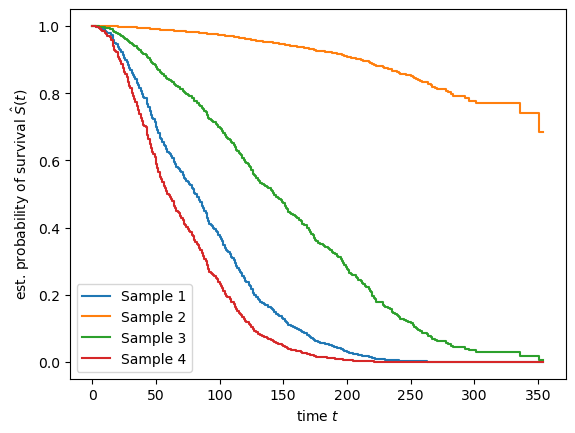

In [31]:
pred_surv = estimator.predict_survival_function(KM_pred)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [32]:
#Измеряем Harrell’s concordance index or c-index.
from sksurv.metrics import concordance_index_censored

In [33]:
prediction = estimator.predict(X_pandas)
result = concordance_index_censored(struct_y_train["overall_survival"], struct_y_train["overall_survival_months"], prediction)
result[0]

0.8483379214249008

In [34]:
#the same
estimator.score(X_pandas, struct_y_train)

0.8483379214249008

In [35]:
#feature selection
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_pandas.values, struct_y_train)
pd.Series(scores, index=X_pandas.columns).sort_values(ascending=False)

cat__death_from_cancer                 0.811423
num__nottingham_prognostic_index       0.627219
num__tumor_size                        0.609968
num__lymph_nodes_examined_positive     0.603089
num__tumor_stage                       0.588652
num__age_at_diagnosis                  0.585212
cat__pr_status                         0.559169
num__neoplasm_histologic_grade         0.558855
cat__type_of_breast_surgery            0.557304
cat__er_status                         0.545162
cat__her2_status_measured_by_snp6      0.537970
cat__er_status_measured_by_ihc         0.537928
num__chemotherapy                      0.535756
cat__her2_status                       0.533732
cat__inferred_menopausal_state         0.523845
cat__pam50_+_claudin-low_subtype       0.521229
num__radio_therapy                     0.520697
cat__tumor_other_histologic_subtype    0.519003
num__mutation_count                    0.518637
cat__primary_tumor_laterality          0.512528
cat__cellularity                       0

Здесь можно сказать, что модель неплохо предсказывает, но есть большие сомнения по признаку death_from_cancer (см. выше).
Попробуем его убрать и посмотрим результат.

In [36]:
X_pandas_24 = X_pandas.copy()
X_pandas_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)

In [37]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_pandas_24, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [38]:
pd.Series(estimator.coef_, index=X_pandas_24.columns)

num__age_at_diagnosis                  0.612801
num__chemotherapy                      0.098876
num__neoplasm_histologic_grade        -0.014504
num__hormone_therapy                  -0.034465
num__lymph_nodes_examined_positive     0.166739
num__mutation_count                    0.005482
num__nottingham_prognostic_index       0.142651
num__radio_therapy                    -0.123100
num__tumor_size                        0.105415
num__tumor_stage                       0.120190
cat__type_of_breast_surgery            0.063776
cat__cancer_type_detailed              0.144064
cat__cellularity                      -0.000632
cat__pam50_+_claudin-low_subtype       0.006366
cat__er_status_measured_by_ihc        -0.021453
cat__er_status                        -0.387349
cat__her2_status_measured_by_snp6     -0.075584
cat__her2_status                       0.407798
cat__tumor_other_histologic_subtype   -0.093551
cat__inferred_menopausal_state         0.414627
cat__integrative_cluster               0

In [39]:
KM_pred_24 = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0]},
     columns=X_pandas_24.columns, orient='index')
KM_pred_24


,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0


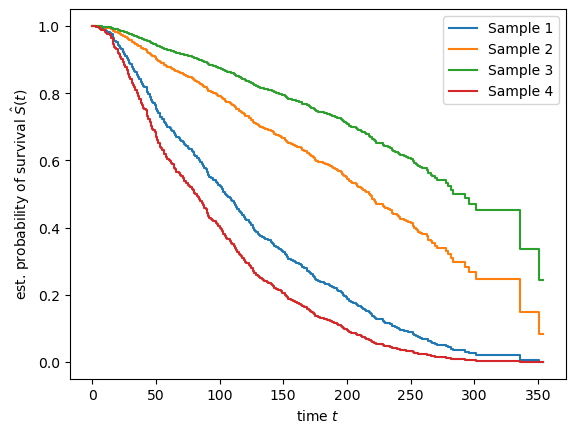

In [40]:
pred_surv = estimator.predict_survival_function(KM_pred_24)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [41]:
prediction = estimator.predict(X_pandas_24)
result = concordance_index_censored(struct_y_train["overall_survival"], struct_y_train["overall_survival_months"], prediction)
result[0]

0.683613916806236

что и требовалось доказать...

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])
                 

In [49]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, X_pandas_24.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_pandas_24, struct_y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
23,24,{'select__k': 24},0.644991,0.694336,0.672932,0.670753,0.020204,1,0.695512,0.674419,0.689064,0.686332,0.008825
22,23,{'select__k': 23},0.641343,0.694394,0.673823,0.669853,0.021839,2,0.694237,0.674385,0.687379,0.685334,0.008232
15,16,{'select__k': 16},0.649611,0.687136,0.670608,0.669118,0.015356,3,0.684847,0.663430,0.679182,0.675819,0.009061
17,18,{'select__k': 18},0.647178,0.687711,0.672018,0.668969,0.016687,4,0.689118,0.670932,0.680020,0.680023,0.007424
16,17,{'select__k': 17},0.649332,0.688401,0.668927,0.668887,0.015950,5,0.688135,0.664517,0.678616,0.677089,0.009702
14,15,{'select__k': 15},0.648796,0.687056,0.670348,0.668733,0.015661,6,0.684431,0.663640,0.678769,0.675613,0.008776
18,19,{'select__k': 19},0.643150,0.689816,0.673011,0.668659,0.019298,7,0.689980,0.671206,0.684791,0.681993,0.007916
20,21,{'select__k': 21},0.642871,0.690012,0.672650,0.668511,0.019466,8,0.690746,0.671164,0.684811,0.682240,0.008198
19,20,{'select__k': 20},0.641945,0.690023,0.671984,0.667984,0.019830,9,0.690399,0.671391,0.684528,0.682106,0.007946
21,22,{'select__k': 22},0.640573,0.688643,0.674240,0.667819,0.020143,10,0.693368,0.671459,0.686150,0.683659,0.009116


In [52]:
pipe.set_params(**gcv.best_params_)
pipe.fit(X_pandas_24, struct_y_train)

transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=columns[transformer.get_support()])

NameError: name 'columns' is not defined